# COGS 108 - Final Project 

# Overview

When the perception of enjoying a park, rec center, or any outdoor space, is influenced by the environmental context. If there was a lot of garbage or terrible air quality hovering over one of these spaces, it is logical to think that this would degrade the experience. In this project, I will attempt to predict the experience of a park (via proxy of yelp ratings) with environmental data in or around the park. Overall, I found that yelp ratings are not influenced much by environmental data.

# Name & GitHub

- Name: Jacob Doering-Powell
- GitHub Username: jacobdp24

# Research Question

Is it possible to predict a yelp rating for a park based on contextual environmental data, and therefore do environmental contexts have an impact on the perception of a park?

## Background and Prior Work

Predicting yelp ratings has been done in many contexts, and is often done by analyzing the words or sentiment of a review. However, I wanted to try and predict yelp ratings of parks, rec centers, and open spaces, by external environmental factors. Although I could not find a study directly trying to predict yelp ratings off of environmental data, I found a study relating to how the public perceives a park based on the environment and how local authorities should respond. It was found that increased use of a park leads to "soil erosion and compaction, damage to vegetation, disturbance to wildlife, water pollution, increased fire frequency, vandalism and noise" [1]. In response to this, there needs to be proper planning, regulation, and education [1]. 

I also found a study that attempts to predict yelp ratings from external factors, not just the review text. This study wants to predict yelp ratings based on business attributes in order to show business owners what factors might be most important [2]. My project would hope to do an analagous function. Predict yelp ratings from environmental data in order to show the Parks and Rec Department which environemtal factors they should address to influence perception and enjoyment the most.

References (include links):
- 1) https://link.springer.com/chapter/10.1007/978-3-642-76502-5_13
- 2) https://scholars.unh.edu/cgi/viewcontent.cgi?article=1379&context=honors

# Hypothesis


The Parks and Rec Department would most likely want a way to predict yelp ratings from environmental data, and thus could extract some relationship between environmental data and the public perception of the parks. It is reasonable to think that the level of enjoyment of an outdoor area will be influenced by environmental factors such as traffic, air quality, and waste. Therefore, I think environmental data will be predictive of yelp ratings, or at least some subset of them.

# Dataset(s)

- Dataset Name: calenviroscreen-final-report.csv
- Link to the dataset: https://data.ca.gov/dataset/calenviroscreen-2-0
- Number of observations: 8035

This dataset contains a multitude of environmental readings for specific latitudes and longitudes within California cities. 

- Dataset Name: yelp_SD_parks.csv
- Link to the dataset: https://www.yelp.com/developers/documentation/v3/business_search
- Number of observations: 833

This dataset contains information about each park, rec center, and green space that has been reviewed in San Diego. Specifically, it has the names, ratings, addresses, longitude, latidude, phome number, id, url, review count, and if it is closed.


To combine these datasets, I will merge on the latitudes and longitudes, using a heuristic only using two significant digits after a lat long reading to match them.

# Setup

In [371]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

sns.set()
sns.set_context('talk')

path = '../data/'
park_meta = pd.read_csv(path + 'yelp_SD_parks.csv')
environment = pd.read_csv(path + 'calenviroscreen-final-report.csv')
environment = environment[['California County', 'Ozone', 'Ozone Pctl','PM2.5','PM2.5 Pctl',
                           'Diesel PM', 'Diesel PM Pctl', 'Drinking Water','Drinking Water Pctl', 
                           'Pesticides', 'Pesticides Pctl', 'Tox. Release','Tox. Release Pctl', 
                           'Traffic', 'Traffic Pctl', 'Cleanup Sites','Cleanup Sites Pctl', 
                           'Groundwater Threats', 'Groundwater Threats Pctl','Haz. Waste', 'Haz. Waste Pctl', 
                           'Imp. Water Bodies','Imp. Water Bodies Pctl', 'Solid Waste', 'Solid Waste Pctl',
                           'Pollution Burden', 'Pollution Burden Score', 'Pollution Burden Pctl', 'Asthma', 
                           'Asthma Pctl', 'Low Birth Weight','Low Birth Weight Pctl', 'Education', 'Education Pctl',
                           'Linguistic Isolation', 'Linguistic Isolation Pctl', 'Poverty',
                           'Poverty Pctl', 'Unemployment', 'Unemployment Pctl', 'Pop. Char. ',
                           'Pop. Char. Score', 'Pop. Char. Pctl', 'Location 1']]


# Data Cleaning

To clean the data, I first extract only San Diego data out of the environmental dataset. Then I extract the latitudes, longitudes, and zipcodes out of this subset. I merge the park information dataset with the environemtal dataset on zipcodes. Once I have them merged, I only keep observations that have the same latitude (up to the second digit after the decimal) and longitude (up to the second digit after the decimal). This assumes that environmental readings calculated at a specific lat, long will carry over to whatever the closest park based on the rounding heuristic. Now I have environmental readings mapped to specific parks (369 obervations). I filter out unecessary environmental readings in this merged dataset, and fix the names of the columns so they are easier to work with when predicting later.

In [341]:
environment = environment[environment['California County'] == 'San Diego']
def get_latitutude_longitude(location):
    split_location = location.split('\n')
    lat_long = split_location[1]
    split_lat_long = lat_long.replace(',', '').replace('(', '').replace(')', '').split(' ')
    lat = float(split_lat_long[0])
    long = float(split_lat_long[1])
    return lat, long

def get_zip(location):
    split_location = location.split('\n')
    city_zip = split_location[0]
    return city_zip.split(' ')[-1]

def get_city(location):
    zipcode = get_zip(location)
    split_location = location.split('\n')
    city_zip = split_location[0]
    return city_zip.replace(' ' + zipcode, '')

def get_zip_from_address(address):
    return address.split(' ')[-1]

def get_city_from_address(address):
    zipcode = get_zip_from_address(address)
    street_city = address.replace(', CA ' + zipcode, '')
    return street_city.split(' ')[-1]

lat, long = [], []
for l in environment['Location 1']:
    latitude, longitude = get_latitutude_longitude(l)
    lat.append(latitude)
    long.append(longitude)


environment['latitude'] = lat
environment['longitude'] = long
environment['zipcode'] = environment['Location 1'].apply(get_zip)
environment['city'] = environment['Location 1'].apply(get_city)
park_meta['zipcode'] = park_meta['address'].apply(get_zip_from_address)
park_meta['city'] = park_meta['address'].apply(get_city_from_address)
merged = park_meta.merge(environment, on='zipcode', how='inner')
decimals = 2
merged = merged[round(merged['longitude_x'], decimals) == round(merged['longitude_y'], decimals)]
merged = merged[round(merged['latitude_x'], decimals) == round(merged['latitude_y'], decimals)]
park_list = set(merged['name'])
merged = merged[['name', 'rating', 'review_count', 'Ozone', 'Ozone Pctl','PM2.5','PM2.5 Pctl', 'Drinking Water',
                 'Drinking Water Pctl', 'Pesticides', 'Pesticides Pctl', 'Tox. Release','Tox. Release Pctl', 
                 'Traffic', 'Traffic Pctl','Groundwater Threats', 'Groundwater Threats Pctl','Haz. Waste', 'Haz. Waste Pctl', 
                 'Imp. Water Bodies','Imp. Water Bodies Pctl', 'Solid Waste', 'Solid Waste Pctl',
                 'Pollution Burden Score', 'Asthma', 'Asthma Pctl']]
new_columns = [c.replace(' ', '').replace('.','') for c in merged.columns]
merged.columns = new_columns
merged

,name,rating,review_count,Ozone,OzonePctl,PM25,PM25Pctl,DrinkingWater,DrinkingWaterPctl,Pesticides,...,GroundwaterThreatsPctl,HazWaste,HazWastePctl,ImpWaterBodies,ImpWaterBodiesPctl,SolidWaste,SolidWastePctl,PollutionBurdenScore,Asthma,AsthmaPctl
3,Balboa Park,5.0,2105,0.001451,7.70,10.475571,54.83,233.407874,30.65,2.185167,...,93.56,2.435,93.74,7,71.63,1.0,37.88,6.785671,69.757919,87.30
12,Waterfront Park,4.5,242,0.001146,6.36,10.386963,53.42,233.407874,30.65,0.000000,...,97.19,1.500,90.14,6,63.56,0.0,0.00,5.595830,69.940000,87.44
53,The Children's Park,3.0,9,0.000863,5.21,10.369884,53.27,233.407874,30.65,0.000000,...,99.32,1.250,88.51,8,76.53,2.0,58.45,5.500546,69.940768,87.45
58,Tweet Street Park,4.5,22,0.000964,5.53,10.396018,53.56,233.407874,30.65,0.000000,...,98.93,2.800,94.57,8,76.53,0.5,23.19,5.524064,69.940000,87.44
67,Balboa Park Kids Playground,4.0,13,0.001451,7.70,10.475571,54.83,233.407874,30.65,2.185167,...,93.56,2.435,93.74,7,71.63,1.0,37.88,6.785671,69.757919,87.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6647,Highland Ranch Park,4.0,16,0.016205,36.12,10.403074,53.66,224.223441,25.71,0.000000,...,30.88,0.160,50.42,0,0.00,0.0,0.00,3.079404,15.918398,4.33
6661,Belle Terre Landscapes,5.0,20,0.018262,38.21,10.203439,51.33,262.466327,34.46,0.811336,...,10.03,0.000,0.00,0,0.00,0.0,0.00,4.004849,15.514035,3.93
6671,The Shop: Pizza + Cocktails,4.5,109,0.018262,38.21,10.203439,51.33,262.466327,34.46,0.811336,...,10.03,0.000,0.00,0,0.00,0.0,0.00,4.004849,15.514035,3.93
6681,Day of LOVE,4.5,26,0.018262,38.21,10.203439,51.33,262.466327,34.46,0.811336,...,10.03,0.000,0.00,0,0.00,0.0,0.00,4.004849,15.514035,3.93


# Data Analysis & Results

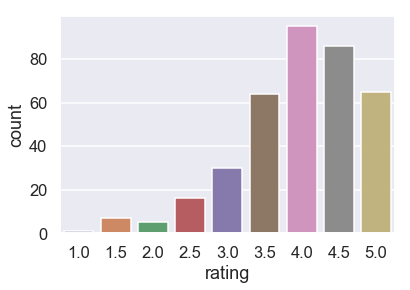

In [344]:
sns.countplot(data=merged, x='rating')

Here we can see the distribution of ratings. It is almost a normal distribution, but the distribution is skewed towards the right (higher ratings).

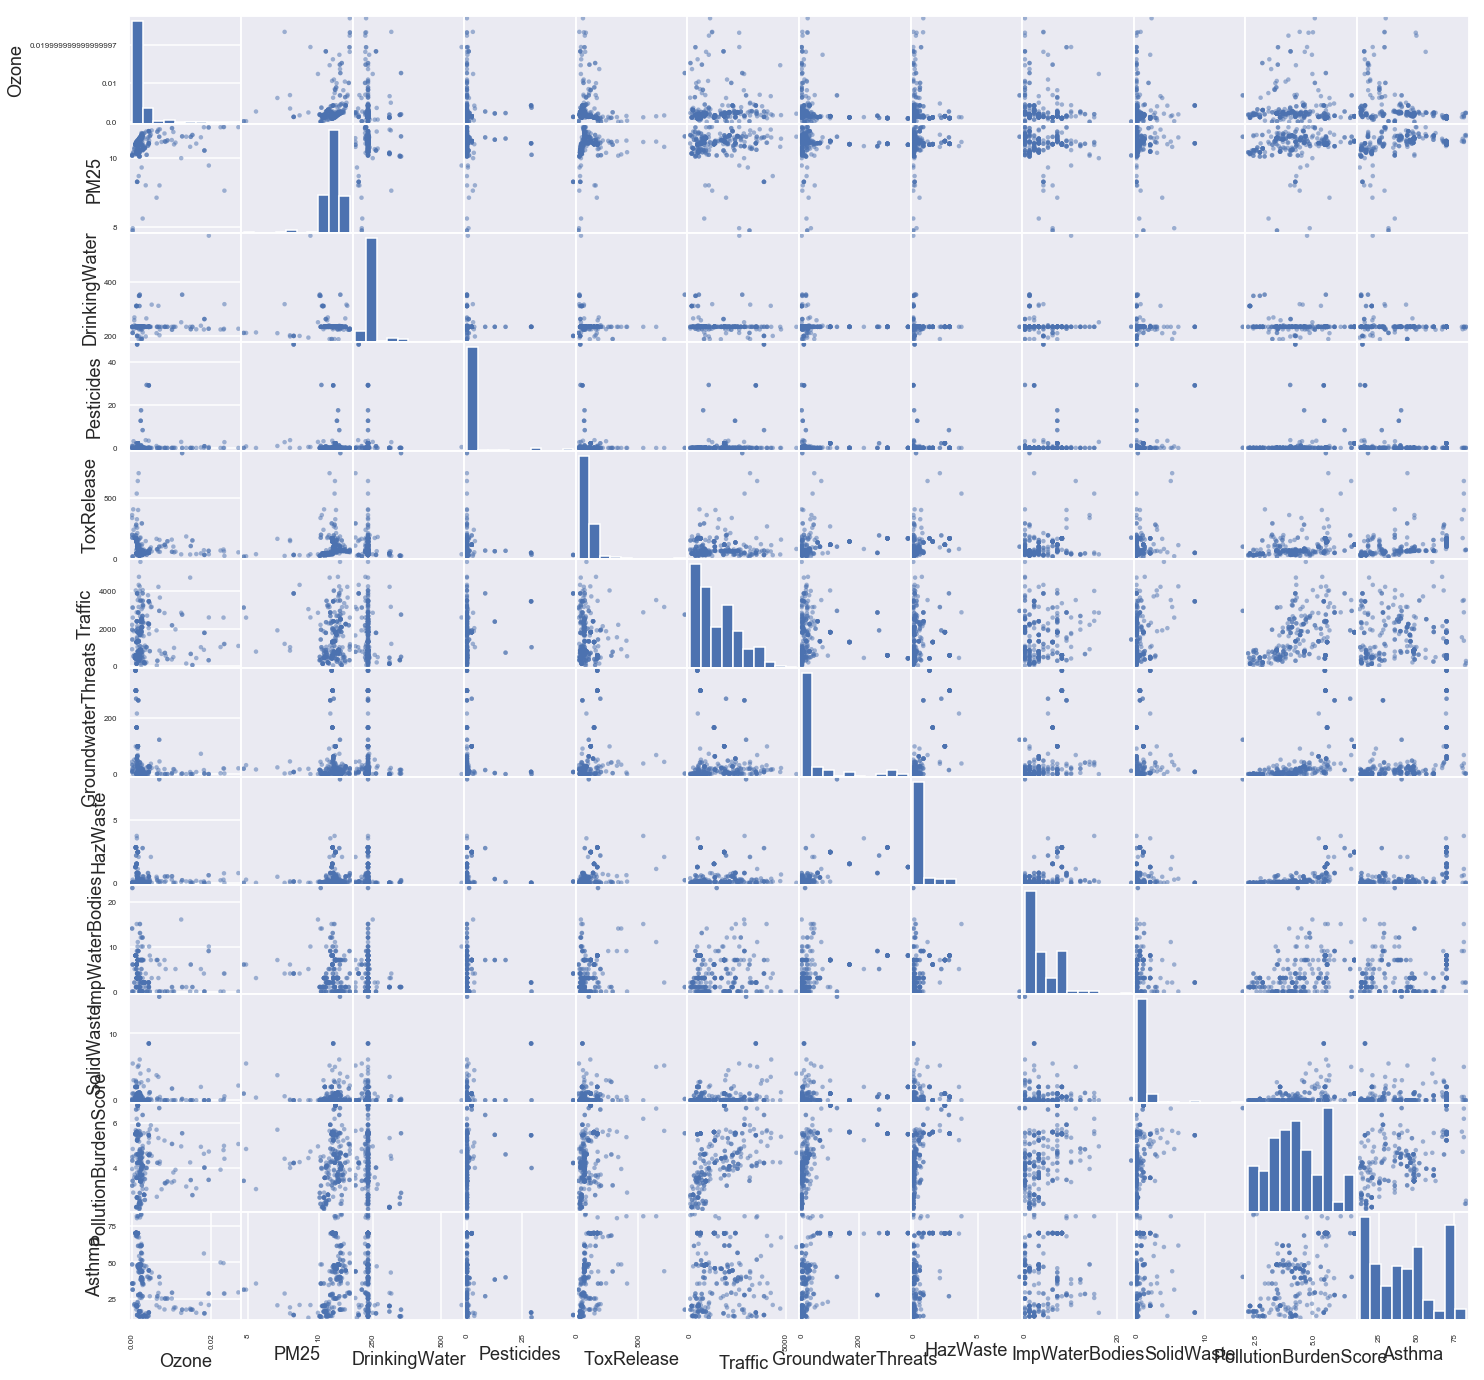

In [345]:
non_pctl = [c for c in merged.columns if 'Pctl' not in c]
only_pctl = ['name', 'rating', 'review_count'] + [c for c in merged.columns if 'Pctl' in c]
merged = merged[non_pctl]
fig = pd.plotting.scatter_matrix(merged[merged.columns[3:]], figsize=(24,24))

The scatter matrix is useful in seeing how different variables we could use for prediction. These relationships are important so we avoid multicollinearity. For instance, there seems to be a relationship between asthma and the pollution burden score, as such they should not be included together as predictive variables. 

In [346]:
equation = 'rating ~ Ozone'
outcome, predictors = patsy.dmatrices(equation, merged)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(equation)
print(res.summary())

rating ~ Ozone
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.833
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.177
Time:                        00:49:32   Log-Likelihood:                -444.11
No. Observations:                 369   AIC:                             892.2
Df Residuals:                     367   BIC:                             900.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0210      0.053     

simple linear regression with one variable does not do much, it has a low R-Squared value

In [347]:
equation = 'rating ~ Traffic + Ozone'
outcome, predictors = patsy.dmatrices(equation, merged)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(equation)
print(res.summary())

rating ~ Traffic + Ozone
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.350
Date:                Wed, 16 Dec 2020   Prob (F-statistic):             0.0969
Time:                        00:49:32   Log-Likelihood:                -442.68
No. Observations:                 369   AIC:                             891.4
Df Residuals:                     366   BIC:                             903.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1166      

multi-linear regression with traffic and Ozone seems to fair a bit better in terms of R-squared, but it's still very low and there seems to be some multicollinearity going on

In [348]:
equation = 'rating ~ '
equation += ' + '.join([c for c in merged.columns[3:]])
outcome, predictors = patsy.dmatrices(equation, merged)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(equation)
print(res.summary())

rating ~ Ozone + PM25 + DrinkingWater + Pesticides + ToxRelease + Traffic + GroundwaterThreats + HazWaste + ImpWaterBodies + SolidWaste + PollutionBurdenScore + Asthma
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.749
Date:                Wed, 16 Dec 2020   Prob (F-statistic):             0.0553
Time:                        00:49:32   Log-Likelihood:                -434.46
No. Observations:                 369   AIC:                             894.9
Df Residuals:                     356   BIC:                             945.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err

adding in all variables helps the R-squared value quite a bit, but there still seems to be multicollinearity. Let's see if I can find a good combination of variables that does not have multicollinearity.

In [349]:
columns_to_keep = ['name', 'rating', 'review_count', 'PM25', 'ImpWaterBodies', 'SolidWaste', 'PollutionBurdenScore', 'HazWaste']
columns_to_keep = [c.replace(' ', '').replace('.', '') for c in columns_to_keep]
subset = merged[columns_to_keep]
subset

,name,rating,review_count,PM25,ImpWaterBodies,SolidWaste,PollutionBurdenScore,HazWaste
3,Balboa Park,5.0,2105,10.475571,7,1.0,6.785671,2.435
12,Waterfront Park,4.5,242,10.386963,6,0.0,5.595830,1.500
53,The Children's Park,3.0,9,10.369884,8,2.0,5.500546,1.250
58,Tweet Street Park,4.5,22,10.396018,8,0.5,5.524064,2.800
67,Balboa Park Kids Playground,4.0,13,10.475571,7,1.0,6.785671,2.435
...,...,...,...,...,...,...,...,...
6647,Highland Ranch Park,4.0,16,10.403074,0,0.0,3.079404,0.160
6661,Belle Terre Landscapes,5.0,20,10.203439,0,0.0,4.004849,0.000
6671,The Shop: Pizza + Cocktails,4.5,109,10.203439,0,0.0,4.004849,0.000
6681,Day of LOVE,4.5,26,10.203439,0,0.0,4.004849,0.000


In [350]:
equation = 'rating ~ '
equation += ' + '.join([c for c in subset.columns[3:]])
outcome, predictors = patsy.dmatrices(equation, subset)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(equation)
print(res.summary())

rating ~ PM25 + ImpWaterBodies + SolidWaste + PollutionBurdenScore + HazWaste
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.172
Date:                Wed, 16 Dec 2020   Prob (F-statistic):             0.0567
Time:                        00:49:32   Log-Likelihood:                -439.59
No. Observations:                 369   AIC:                             891.2
Df Residuals:                     363   BIC:                             914.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

We have found a set of variables that don't have strong multicollinearity, but our R-Squared value falls. Lets see if more complex models, not just linear regression, can help us improve our predictions. We will make a function that can make cross validated predictions with a model, and then plot the predicted yelp ratings vs. measured yelp ratings so we can see how the models are doing.

In [353]:
def predict_and_plot(model, data, model_name=None):
    if model_name:
        print(model_name)
    y = data['rating']
    X = data[data.columns[3:]]
    predicted = cross_val_predict(model, X, y, cv=10)
    score = r2_score(data['rating'], predicted)
    print('R-squared value: ' + str(score))
    fig, ax = plt.subplots()
    ax.scatter(y, predicted)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('measured yelp rating')
    ax.set_ylabel('predicted yelp rating')
    plt.show()

linear regression
R-squared value: -0.031927546593529144


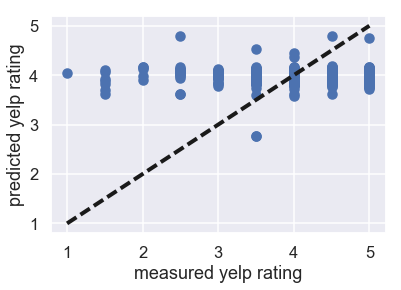

In [368]:
reg = linear_model.LinearRegression()
predict_and_plot(reg, subset, model_name='linear regression')

baseline linear prediction seems to be focusing around predicting the average, and has a poor R-squared value. This indicates our environmental data does not impact the yelp rating.

lasso regression
R-squared value: -0.019470648381770594


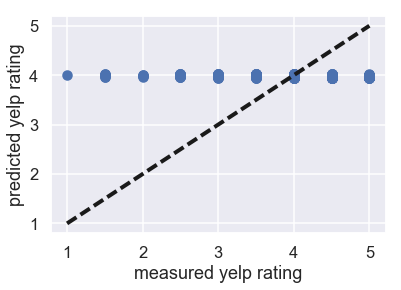

In [354]:
lasso = linear_model.Lasso()
predict_and_plot(lasso, subset, model_name='lasso regression')

lasso regression (linear regression with a regularization term) does not fare very well, and essentially predicts the average score for every prediction as can be seen in the plot. It does slightly better than linear regression, but again does not indicate yelp ratings are impacted by environmental data.

ridge regression
R-squared value: -0.03089690546801971


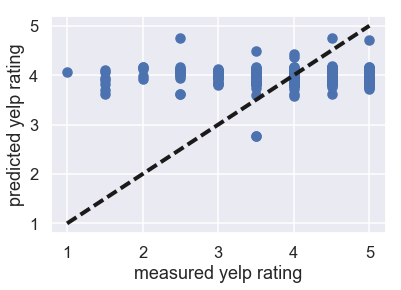

In [355]:
ridge = linear_model.Ridge()
predict_and_plot(ridge, subset, model_name='ridge regression')

Although the r-squared value falls, it is clear there is more variation in predictions when compred to lasso regression, which could be seen as an improvement rather than just predicting 4 every time. Still does not show that yelp ratings are affected by the environment.

random forest


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

R-squared value: 0.01816581462114053


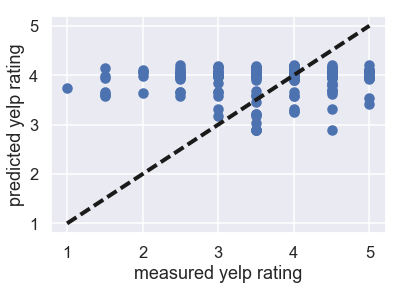

In [361]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
predict_and_plot(regr, subset, model_name='random forest')

random forest performs better than ridge regression, lasso regression, and linear regression. It is starting to predict into the 3-4 rating zone, not just 4's. As such, the R-squared value gets a boost. Still an extremely small r-squared though, so it suggests that environmental data has a very low impact on yelp ratings. 

neural net
R-squared value: -0.18025676048999717


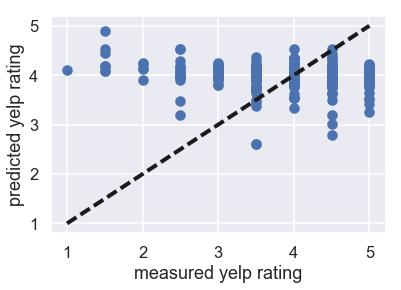

In [365]:
regr = MLPRegressor(random_state=1, max_iter=1000)
predict_and_plot(regr, subset, model_name='neural net')

the neural net does not perform very well. This is expected though, because the training data is quite small. Neural nets are known to perform poorly on such datasets, and simpler linear models normally perform better. The worst performance is with the lower rated parks.

adaboost
R-squared value: -0.0746335074377853


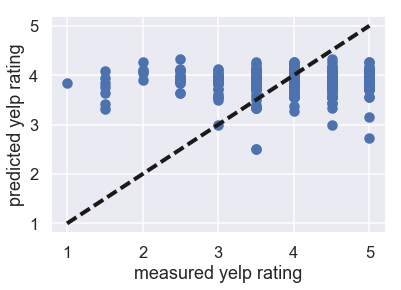

In [366]:
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
predict_and_plot(regr, subset, model_name='adaboost')

adaboost does not seem to fare better than the neural net or the baseline linear regression. It seems there is a valley of complexity in terms of something slightly more complex than linear regression does better, but really complex models like neural nets or adaboost begin to fair worse. This could be because of the small training data though, and the data does not have many negative (low) reviews, so complex models will not be able to handle these outliers. Overall it seems that environmental factors in this dataset have little to no impact on the yelp ratings.

# Ethics & Privacy

Yelp ratings and the environmetal readings are public record. There is no personal identifiable information that I used in my analysis. Privacy was less of an issue in this study. However, the ethics of the study should be considered.

I'm only studying a subset of environmental factors, so I could be putting too much weight on them, thus ignoring other important environmental factors that could be impacting the public perception of parks. The problem is that more attention would be paid to factors that were considered in the study and it could lead to a feedback loop of sorts, where time is spent improving say solid waste, when fire hazards actually needed to be studied (which were not measured). Furthermore, these should be taken with a grain of salt because yelp ratings are not a perfect proxy to how people actually feel. There are bots and trolls who could leave fake reviews, skewing the perception.

# Conclusion & Discussion

To reiterate my research question: Is it possible to predict a yelp rating for a park based on contextual environmental data, and therefore do environmental contexts have an impact on the perception of a park?

From my analysis, I can say that the environmental data I used did not reliably predict park yelp ratings. I tried many different models, and none of them had high R-squared values. Due to not being able to predict, I can say that the environmental contexts measurements in this dataset do not have an impact on yelp ratings for parks in this dataset, and by proxy do not have a meaningful impact on how people perceive the parks.

One of the main issues with my analysis comes down to data size. There was not enough data to train a complex model. This is why simpler models performed better on this dataset. Another limitation of the study is that yelp ratings are highly subjective. There may be no real reason a person leaves a 5 star or a 1 star. They could have had a nice lunch before writing the review and that influences their decision to rate a 4 instead of a 2. It is a highly subjective metric, and that should be one of the main takeways from this analysis. 